In [2]:
import sys
import os
import json
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style()
import pandas as pd

# import dysts
from dysts.datasets import *
from dysts.flows import *
from dysts.base import *
from dysts.utils import *
from dysts.analysis import *

import degas as dg
dg.set_style()

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Tune hyperparameters

In [49]:
%%bash

# python3 find_hyperparameters.py

Process is terminated.


# Run and record forecasts on test data

In [73]:
%%bash --out output --err error

# python3 compute_benchmarks.py

Process is terminated.


## Load Forecasting Benchmark Results

In [27]:
import os
import json

with open(
    os.getcwd()
    + "/results/results_test_univariate__pts_per_period_15__periods_12.json",
    "r",
) as file:
    all_results = json.load(file)

# with open(os.getcwd() + "/results/results_test_univariate__pts_per_period_15__periods_12_noise.json", "r") as file:
#     all_results = json.load(file)

all_results.keys()


## Convert R2 into a distance
all_r2 = list()
for equation_name in all_results:
    for model_name in all_results[equation_name]:
        if model_name == "values":
            continue
        else:
            ## convert r2 to a pseudodistance
            all_results[equation_name][model_name]["r2_score"] = (
                1 - all_results[equation_name][model_name]["r2_score"]
            )

            ## Coefficient of variation must be normed
            all_results[equation_name][model_name]["coefficient_of_variation"] = np.abs(
                all_results[equation_name][model_name]["coefficient_of_variation"]
            )

            ## Drop RMSE because it overlaps with MSE
            all_results[equation_name][model_name].pop("rmse", None)


from darts import TimeSeries
from darts.metrics import mae

wrap_array = lambda x: TimeSeries.from_dataframe(pd.DataFrame(np.squeeze(np.array(x))))
mae_func = lambda x, y: mae(wrap_array(x), wrap_array(y))


## Calculate MASE
for equation_name in all_results:
    baseline_onestep = mae_func(
        all_results[equation_name]["values"][1:],
        all_results[equation_name]["values"][:-1],
    )
    for model_name in all_results[equation_name]:
        if model_name == "values":
            continue
        else:
            mae_val = all_results[equation_name][model_name]["mae"]
            all_results[equation_name][model_name]["mase"] = mae_val / baseline_onestep

## get best models
all_best_models = list()
for equation_name in all_results:
    all_models = list()
    all_smapes = list()
    for model_name in all_results[equation_name]:
        if model_name != "values":
            all_models.append(model_name)
            all_smapes.append(all_results[equation_name][model_name]["smape"])
    all_best_models.append(all_models[np.argmin(all_smapes)])

all_results_transposed = dict()
for model_name in all_results["Lorenz"]:
    if model_name == "values":
        continue
    all_results_transposed[model_name] = dict()
for equation_name in all_results:
    for model_name in all_results[equation_name]:
        if model_name == "values":
            continue
        all_results_transposed[model_name][equation_name] = all_results[equation_name][
            model_name
        ]


hist_values = dict()
for model_name in all_results_transposed:
    smape_vals = list()
    for key in all_results_transposed[model_name]:
        smape_vals.append(all_results_transposed[model_name][key]["smape"])

    hist_values[model_name] = smape_vals.copy()

hist_values_low = hist_values.copy()
# hist_values_high = hist_values.copy()


all_metric_names = list(all_results_transposed["ARIMA"]["Aizawa"].keys())
all_metric_names.remove("prediction")

## Compute forecast metrics
metric_records = dict()
for metric_name in all_metric_names:
    metric_records[metric_name] = list()
for model_name in all_results_transposed:
    for equation_name in all_results_transposed[model_name]:
        for metric_name in all_metric_names:
            metric_records[metric_name].append(
                all_results_transposed[model_name][equation_name][metric_name]
            )
df_metrics = pd.DataFrame(metric_records)


# df_metrics["coefficient_of_variation"] = np.abs(df_metrics["coefficient_of_variation"])
# df_metrics = df_metrics.drop('rmse', 1)

### Load mathematical properties

In [4]:
import dysts.flows

max_lyap = list()
best_scores = list()
for equation_name in all_results:
    
    all_scores_per_equation = list()
    for model_name in all_results[equation_name]:
        if model_name == "values":
            continue
        all_scores_per_equation.append(all_results[equation_name][model_name]["smape"])
    
    best_scores.append(min(all_scores_per_equation))

    eq = getattr(dysts.flows, equation_name)()
    max_lyap.append(eq.maximum_lyapunov_estimated)
        


### Compare forecasting metrics

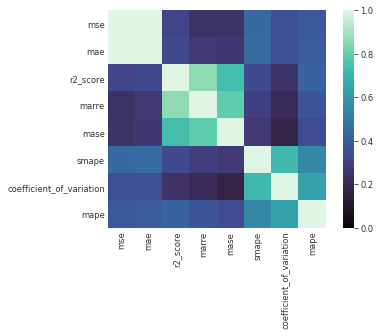

In [5]:

corr_array = np.array(df_metrics.corr(method='spearman'))
np.fill_diagonal(corr_array, np.nan)

metric_sort_inds = np.argsort(np.nanmedian(corr_array, axis=0))[::-1]
metric_sort_inds = np.argsort(np.nanmax(corr_array, axis=0))[::-1]
df_metrics_sorted = df_metrics.iloc[:, metric_sort_inds]


ax = sns.heatmap(df_metrics_sorted.corr(method='spearman'), cmap="mako", vmin=0, vmax=1)
ax.set_aspect('equal')
ax.tick_params(axis='both', which='both', length=0)

# dg.better_savefig("../private_writing/fig_resources/metric_map.png", dpi=600)

### Compare forecasting results against mathematical properties

In [6]:
chosen_metric = "smape"
models_df = dict()
metrics_df = dict()
for equation_name in all_results:
    models_df[equation_name] = dict()
    metrics_df[equation_name] = dict()
    for model_name in all_results[equation_name]:
        if model_name == "values": continue
        models_df[equation_name][model_name] = all_results[equation_name][model_name][chosen_metric]
    
        for metric_name in all_results[equation_name]["ARIMA"]:
            if metric_name == "prediction": continue
            metrics_df[equation_name][metric_name] = all_results[equation_name]["NBEATSModel"][metric_name]
    
    
models_df = pd.DataFrame(models_df).transpose()
metrics_df = pd.DataFrame(metrics_df).transpose()

In [12]:
import dysts.flows

attributes =  ['maximum_lyapunov_estimated', 'kaplan_yorke_dimension', 'multiscale_entropy', 'correlation_dimension']
all_properties = dict()
for equation_name in get_attractor_list():
    eq = getattr(dysts.flows, equation_name)()
    attr_vals = [getattr(eq, item, None) for item in attributes]
    
    all_properties[equation_name] = dict(zip(attributes, attr_vals))
    
all_properties = pd.DataFrame(all_properties).transpose().dropna()

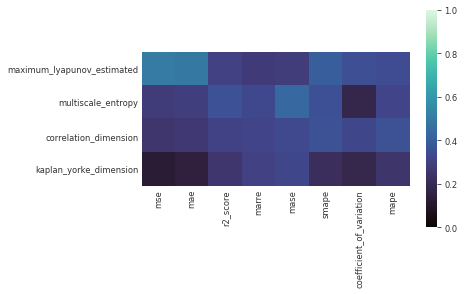

In [14]:
cross_corr = pd.concat([metrics_df, all_properties], axis=1, keys=['metrics_df', 'all_properties']).corr(method="spearman").loc['metrics_df', 'all_properties']
math_sort_inds = np.argsort(np.max(cross_corr, axis=0))[::-1]

ax = sns.heatmap(cross_corr.transpose().iloc[math_sort_inds, metric_sort_inds], cmap="mako", vmin=0, vmax=1)
ax.set_aspect(1)
ax.tick_params(axis='both', which='both', length=0)

# dg.better_savefig("../private_writing/fig_resources/metric_math.png", dpi=600)

In [81]:

## Easiest and hardest systems
print("Easiest systems: ", np.unique(models_df.idxmin(axis=0), return_counts=True))
print("Hardest systems: ", np.unique(models_df.idxmax(axis=0), return_counts=True))


all_median_names = list()
for key in models_df.keys():
    all_median_names.append(models_df[models_df[key] == models_df[key].quantile(interpolation='nearest')].index[0])
    
print("Middle systems: ", np.unique(all_median_names, return_counts=True))

Easiest systems:  (array(['ArnoldWeb', 'StickSlipOscillator', 'Torus'], dtype=object), array([ 1,  5, 10]))
Hardest systems:  (array(['CellularNeuralNetwork', 'Chua', 'CoevolvingPredatorPrey',
       'DoublePendulum', 'HyperQi', 'LuChen', 'SprottTorus',
       'TurchinHanski'], dtype=object), array([2, 1, 2, 1, 2, 1, 6, 1]))
Middle systems:  (array(['ChenLee', 'Duffing', 'Finance', 'Halvorsen', 'HyperYan',
       'JerkCircuit', 'LorenzStenflo', 'OscillatingFlow', 'Rossler',
       'Rucklidge', 'SprottA', 'SprottF', 'SprottG', 'ThomasLabyrinth'],
      dtype='<U15'), array([1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1]))


/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/dysts/base.py:166: UserWarning: This system has at least one unbounded variable, which has been mapped to a bounded domain. Pass argument postprocess=False in order to generate trajectories from the raw system.
  warnings.warn("This system has at least one unbounded variable, which has been mapped to a bounded domain. Pass argument postprocess=False in order to generate trajectories from the raw system.")


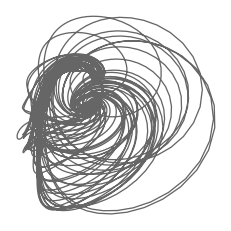

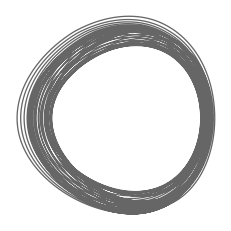

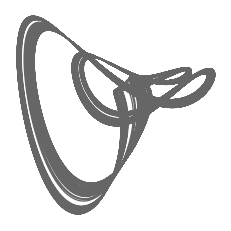

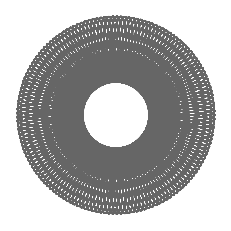

In [86]:
from dysts.flows import SprottTorus, StickSlipOscillator, Torus, SprottG

style1 = {"color": (0.4, 0.4, 0.4)}

plt.figure()
sol = SprottTorus().make_trajectory(50000, resample=True, pts_per_period=400)
plt.plot(sol[:, 0], sol[:, 1], **style1)
dg.fixed_aspect_ratio(1)
dg.vanish_axes()
dg.better_savefig("../private_writing/fig_resources/sprott_torus.png", dpi=600)



plt.figure()
sol = StickSlipOscillator().make_trajectory(50000, resample=True, pts_per_period=400)
plt.plot(sol[:, 0], sol[:, 1], **style1)
dg.fixed_aspect_ratio(1)
dg.vanish_axes()
dg.better_savefig("../private_writing/fig_resources/stickslip.png", dpi=600)



plt.figure()
sol = SprottG().make_trajectory(50000, resample=True, pts_per_period=400)
plt.plot(sol[:, 0], sol[:, 1], **style1)
dg.fixed_aspect_ratio(1)
dg.vanish_axes()
dg.better_savefig("../private_writing/fig_resources/sprottg.png", dpi=600)

plt.figure()
sol = Torus().make_trajectory(50000, resample=True, pts_per_period=400)
plt.plot(sol[:, 0], sol[:, 1], **style1)
dg.fixed_aspect_ratio(1)
dg.vanish_axes()
dg.better_savefig("../private_writing/fig_resources/torus.png", dpi=600)

### Compare different forecasting models

In [21]:
import pandas as pd

def mirror_df(df, mirror_val=0):
    """
    Create a mirrored augmented dataframe. Used
    for setting the right boundary conditions on kernel 
    density plots
    """
    if np.isscalar(mirror_val):
        return pd.concat([df, mirror_val - df])
    else:
        all_out_df = [df]
        for val in mirror_val:
            all_out_df.append(val - df)
        return pd.concat(all_out_df)
    
dflo = pd.DataFrame.from_dict(hist_values_low)
# dflo  = mirror_df(dflo, [0])
# dflo  = mirror_df(dflo, mirror_val=200)
dflo["Granularity"] = "Coarse"

dfhi = pd.DataFrame.from_dict(hist_values_high)
# dfhi  = mirror_df(dfhi, mirror_val=200)
# dfhi = mirror_df(dfhi, [0])
dfhi["Granularity"] = "Fine"
data = pd.merge(dflo, dfhi, how="outer")

all_model_names = np.array(list(hist_values_high.keys()))
all_medians = [np.median(hist_values_high[name]) for name in hist_values_high]
all_means = [np.mean(hist_values_high[name]) for name in hist_values_high]
sort_order = np.argsort(all_medians)
# data = data[all_model_names[sort_order]]

data_long = pd.melt(data, value_vars=all_model_names[sort_order], id_vars="Granularity")

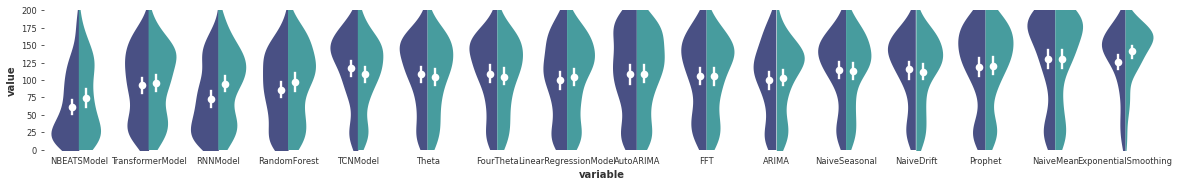

In [58]:
plt.figure(figsize=(20,10))
ax = plt.gca()


ax = sns.violinplot(data=data_long,  x="variable", y="value", hue="Granularity", order=all_model_names[sort_order],
              linewidth=0, size=3, alpha=0.1, split=True, scale="area", inner=None, palette="mako",
                   )
ax = sns.pointplot(data=data_long, x="variable", y="value", hue="Granularity", order=all_model_names[sort_order],
              linewidth=0, size=4, palette={"Coarse": "w", "Fine": "w"}, join=False, ci=99, dodge=0.2)


plt.ylim([0, 200])
dg.fixed_aspect_ratio(1/8)
ax.grid(False)
ax.legend_.remove()

# dg.better_savefig("../private_writing/fig_resources/forecasting_violins.png", dpi=600)

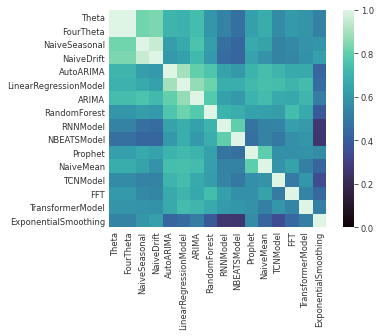

In [26]:
model_records = dict()
for model_name in all_results_transposed.keys():
    model_records[model_name ] = list()
for model_name in all_results_transposed:
    for equation_name in all_results_transposed[model_name]:
        model_records[model_name].append(all_results_transposed[model_name][equation_name]["smape"])
df_models = pd.DataFrame(model_records)


corr_array = np.array(df_models.corr(method='spearman'))
np.fill_diagonal(corr_array, np.nan)

df_models_sorted = df_models.iloc[:, np.argsort(np.nanmedian(corr_array, axis=0))[::-1]]
df_models_sorted = df_models.iloc[:, np.argsort(np.nanmax(corr_array, axis=0))[::-1]]

# df_models_sorted = df_models.iloc[:, sort_order]

ax = sns.heatmap(df_models_sorted.corr(method='spearman'), cmap="mako", vmin=0, vmax=1)
ax.set_aspect('equal')
ax.tick_params(axis='both', which='both', length=0)

# dg.better_savefig("../private_writing/fig_resources/model_correlation_map.png", dpi=600)